# Survival Analysis

### Data description

Data is State-level data from the COVID-19 pandemic in the U.S. Various sources of data have been combined, including confirmed case counts, distribution of age/race/income/political leaning, and population density. 

### Main objectives

The objective is to conduct survival analysis with the state level pandemic data. Although a simple regression to forecast case rates is interesting, some works have also looked into Survival analysis since a time to event analysis is interesting from a public health perspective ([Baird et al., 2024](https://pubmed.ncbi.nlm.nih.gov/38437606/)). Modeling the time til case rates exceed some threshold can indicate how quickly cases are growing. We can also  analyze effect of various factors on hazard rate with CPH regression and check whether results are consistent between CPH and KM. 

### Key findings 

Parameters for proportional effects in CPH regression are consistent with my understanding of these variables. Although there is some overlap in the CIs, we see that risk factors like high population density, black or African American race, low income have >1 multiplicative effect on baseline hazard rate. Other feature like majority Democratic political leaning lead to <1 multiplicative effect on baseline hazard rate. Although higher elderly population is a risk factor, it leans towards <1 multiplicative effect. This may be due to association with other features like high vaccination rate, or lower mobility (compared to eg. children). 

Looking at survival curves within subgroups with and without the feature, results are consistent between CPH regression and Kaplan Meier. CPH regression curves are smoother due to parametric assumptions. 

### Future direction 

One potential flaw is the assumption that covariates have constant proportional effect on baseline hazard regardless of time. We saw that even though e.g. higher elderly population is a risk factor, it leans towards a <1 multiplicative effect on baseline hazard rate. One reason may be due to higher vaccination rate especially in later stages of the pandemic. Checking residuals indicates non stationary and further confirms this idea.

To better differentiate the effect, a few ideas are:
* incorporate data on vaccine rates
* re-run analyses by wave (expect >1 multiplicative effect in earlier waves)
* incorporate time varying covariates (i.e. model variability in effect of covariates on hazard rate over time) ([Example in lifelines module](https://lifelines.readthedocs.io/en/latest/Time%20varying%20survival%20regression.html), [Zhang et al., 2018](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6015946/))

Although I only included static variables in this analysis, time varying variables such as vaccine rates, hospital admission rates, and seasonality may also have been informative. Capturing effect of variable interactions may also help, e.g. elderly population and political leaning.

In [1]:
import os
import re
import glob
import math
import copy
import pickle
import dowhy
import econml
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import causal_analysis_helper
import analysis_helper
import data_helper
import tsa_helper
import config
import utils
# from data_helper import get_OxCGRT_data_loader

importlib.reload(causal_analysis_helper)
importlib.reload(analysis_helper)
importlib.reload(data_helper)
importlib.reload(tsa_helper)
importlib.reload(config)
importlib.reload(utils)

from textwrap import wrap
from dowhy import CausalModel
from datetime import date, datetime

import constants as C
importlib.reload(C)

<module 'constants' from '/Users/yutsumi/cic-covid-working-group/covid-policy/constants.py'>

Load data.

*Load, merge, get columns.*

In [126]:
importlib.reload(data_helper)

# Load data
((subnational_df, national_df, data_to_df,
  data_to_columns, data_to_column_map, OxCGRT_policy_columns),
 (subnational_df_unfiltered, national_df_unfiltered, data_to_df_unfiltered,
  data_to_columns_unfiltered, data_to_column_map_unfiltered, OxCGRT_policy_columns_unfiltered)) = data_helper.load_all_data()

# Post-processing. Update columns info as needed.
subnational_df, national_df, data_to_column_map, outcome_ts_ahead_columns_map,\
diff_policy_index_columns, diff_outcome_columns, date_column, outcome_columns = \
  data_helper.post_process_data(subnational_df, national_df, data_to_column_map, OxCGRT_policy_columns)

subnational_df_unfiltered, national_df_unfiltered, data_to_column_map_unfiltered, outcome_ts_ahead_columns_map_unfiltered,\
diff_policy_index_columns_unfiltered, diff_outcome_columns_unfiltered, _, _ = \
  data_helper.post_process_data(subnational_df_unfiltered, national_df_unfiltered, data_to_column_map_unfiltered, OxCGRT_policy_columns_unfiltered)

# Consolidate/process columns
all_data_columns_map, rcode_to_rname, rname_to_rcode, N_columns, get_dims = \
data_helper.process_columns(subnational_df, data_to_column_map, outcome_ts_ahead_columns_map, diff_outcome_columns, OxCGRT_policy_columns)

all_data_columns_map_unfiltered, _, _, N_columns_unfiltered, get_dims_unfiltered = \
data_helper.process_columns(subnational_df_unfiltered, data_to_column_map_unfiltered, outcome_ts_ahead_columns_map_unfiltered, 
                            diff_outcome_columns_unfiltered, OxCGRT_policy_columns_unfiltered)

all_data_columns = np.concatenate(list(all_data_columns_map.values()))
all_data_columns_unfiltered = np.concatenate(list(all_data_columns_map_unfiltered.values()))

Loading Google Mobility data...
Done!
Loading hospital data...
File was found. Unpickling...
Done!
File was not found. 
Processing data...
Loading demographic data from US Census tables...
Done!
Loading OxCGRT pandemic response data...
Done!
Apply differencing, adjust outcomes by population
----- Policy C -----
----- Policy H -----
----- Policy E -----
----- Policy V -----
----- Policy C -----
----- Policy H -----
----- Policy E -----
----- Policy V -----
Apply differencing, adjust outcomes by population
----- Policy C -----
----- Policy H -----
----- Policy E -----
----- Policy V -----
----- Policy C -----
----- Policy H -----
----- Policy E -----
----- Policy V -----


Fit survival curves.

In [127]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter 
import warnings
import os
# os.chdir('data')
# from colorsetup import colors, palette
# sns.set_palette(palette)

<Axes: xlabel='OxCGRT_Date', ylabel='OxCGRT_ConfirmedCases_diff(7)'>

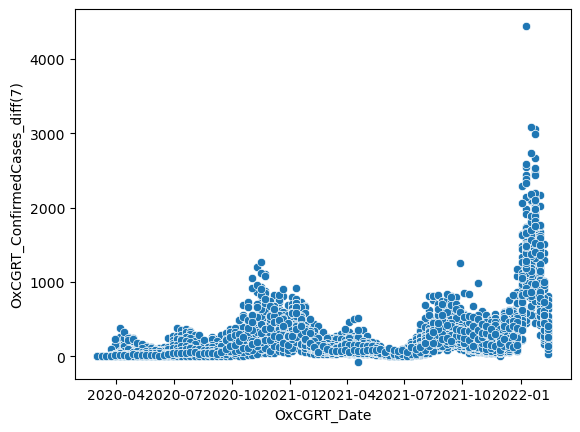

In [128]:
sns.scatterplot(subnational_df, x='OxCGRT_Date', y=diff_outcome_columns[0])

Set event to be when case rate (per 100k people) exceed thresholds (e.g. 50, 150, 300, etc.). 

In [129]:
event_threshold = [50, 150, 300, 500, 750, 1000]

subnational_df_by_region = subnational_df.groupby('OxCGRT_RegionName')
censoring_data = [] # region, wave, censored date, event indicator 1, 2, 3...
for rname in subnational_df.OxCGRT_RegionName.unique():
    region_df = subnational_df_by_region.get_group(rname)
    for wave_ix in range(1, 7):
        for thresh in event_threshold:
            try:
                date, date_ix = region_df.loc[(region_df[f'Wave_{wave_ix}'] == 1) & (region_df[diff_outcome_columns[0]] > thresh)].iloc[0][['OxCGRT_Date', 'OxCGRT_Date_index']]
                censoring_data.append([ rname, f'Wave_{wave_ix}', date, date_ix, thresh, 1 ])
            except:
                date, date_ix = region_df.loc[(region_df[f'Wave_{wave_ix}'] == 1)].iloc[-1][['OxCGRT_Date', 'OxCGRT_Date_index']]
                censoring_data.append([ rname, f'Wave_{wave_ix}', date, date_ix, thresh, 0 ])
                

In [141]:
censoring_df = pd.DataFrame(censoring_data, columns=['RegionName', 'Wave', 'Date', 'Date_index', 'event_threshold', 'event_indicator'])
censoring_df

,RegionName,Wave,Date,Date_index,event_threshold,event_indicator
0,Alaska,Wave_1,2020-05-25,85,50,0
1,Alaska,Wave_1,2020-05-25,85,150,0
2,Alaska,Wave_1,2020-05-25,85,300,0
3,Alaska,Wave_1,2020-05-25,85,500,0
4,Alaska,Wave_1,2020-05-25,85,750,0
...,...,...,...,...,...,...
1795,Wyoming,Wave_6,2022-01-03,673,150,1
1796,Wyoming,Wave_6,2022-01-03,673,300,1
1797,Wyoming,Wave_6,2022-01-10,680,500,1
1798,Wyoming,Wave_6,2022-01-10,680,750,1


Compare Kaplan Meier curves across waves. For each threshold.

In [142]:
from lifelines import KaplanMeierFitter, CoxPHFitter 

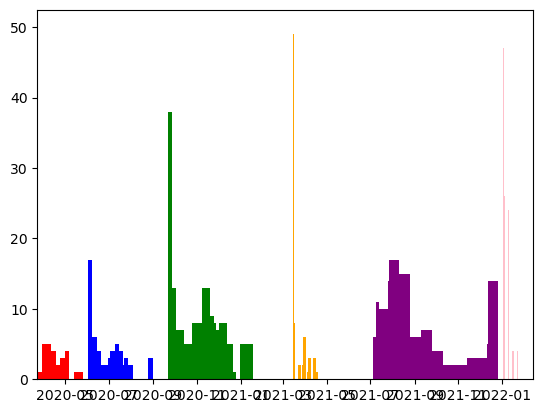

In [143]:
# 1. Plot distributions of censoring variables by wave.
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink']

for thresh in event_threshold:
    for wave_ix,c in zip(range(1,7), colors):
        censoring_df_for_wave_thresh = censoring_df.loc[(censoring_df.Wave == f'Wave_{wave_ix}') & (censoring_df.event_threshold == thresh)]
        plt.hist(censoring_df_for_wave_thresh.loc[censoring_df_for_wave_thresh.event_indicator==1].Date, label=f'Wave_{wave_ix}', color=c)

plt.xlim(censoring_df.Date.min(), censoring_df.Date.max())

*Test thresholds for event.*

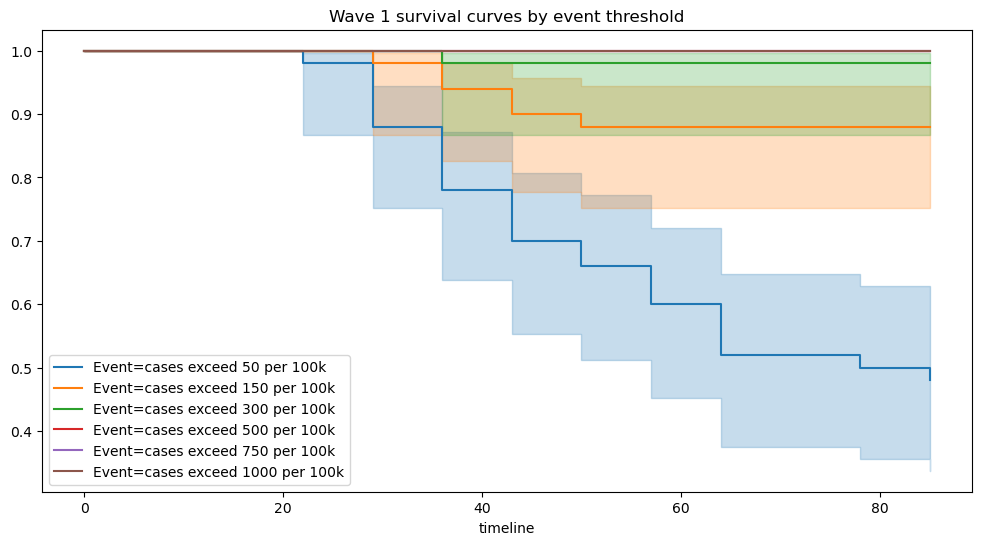

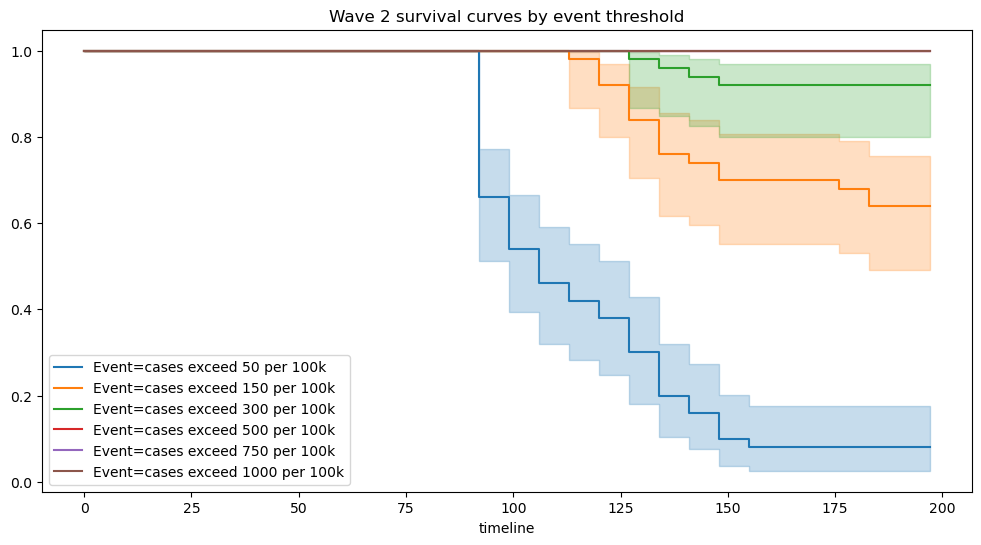

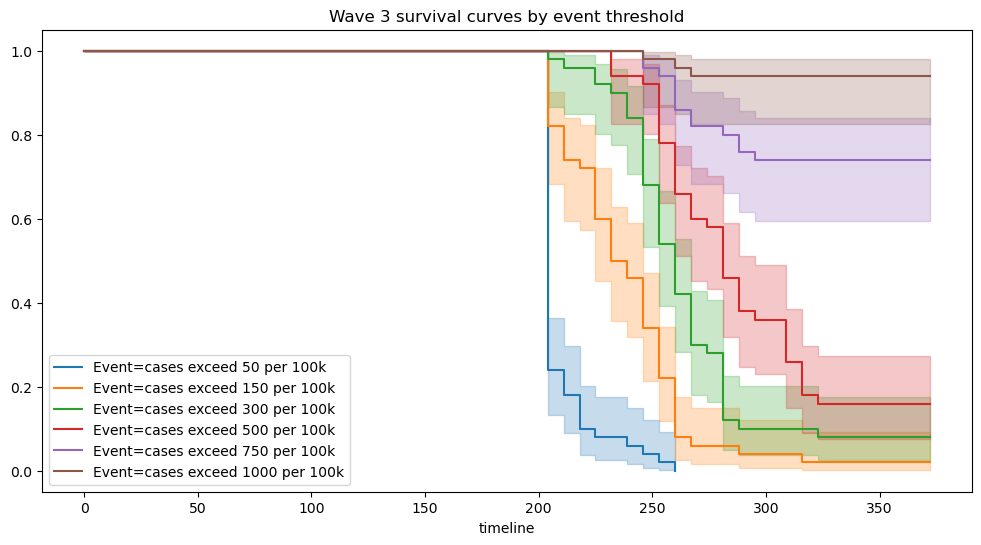

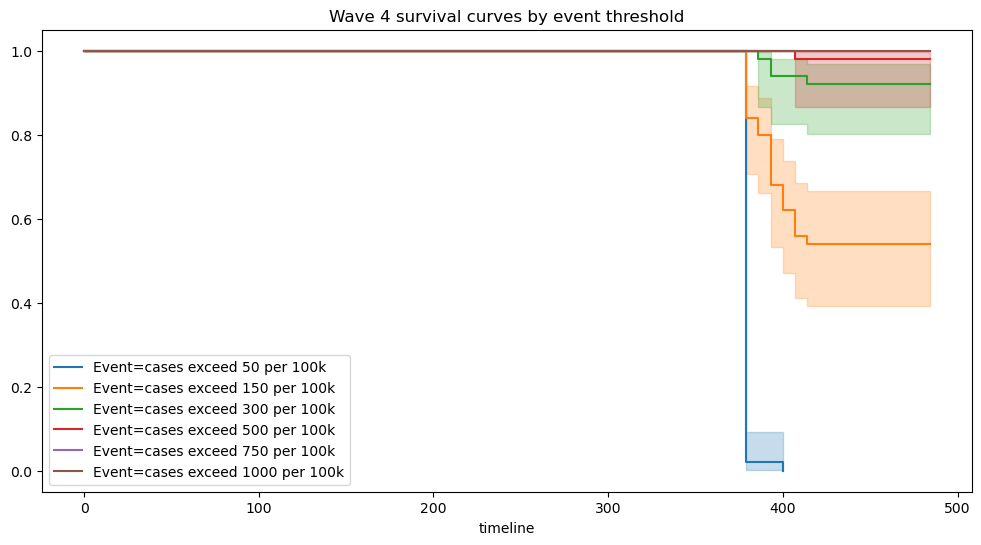

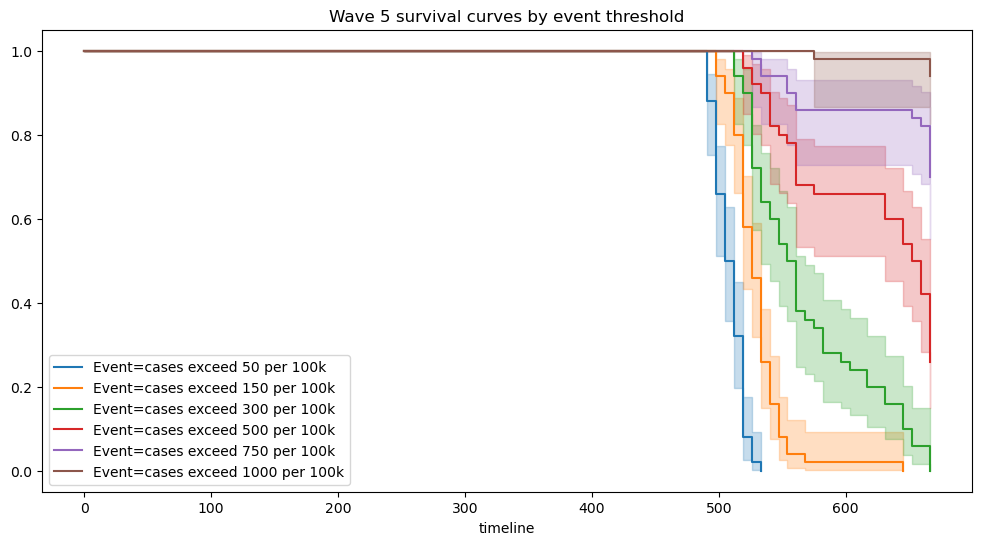

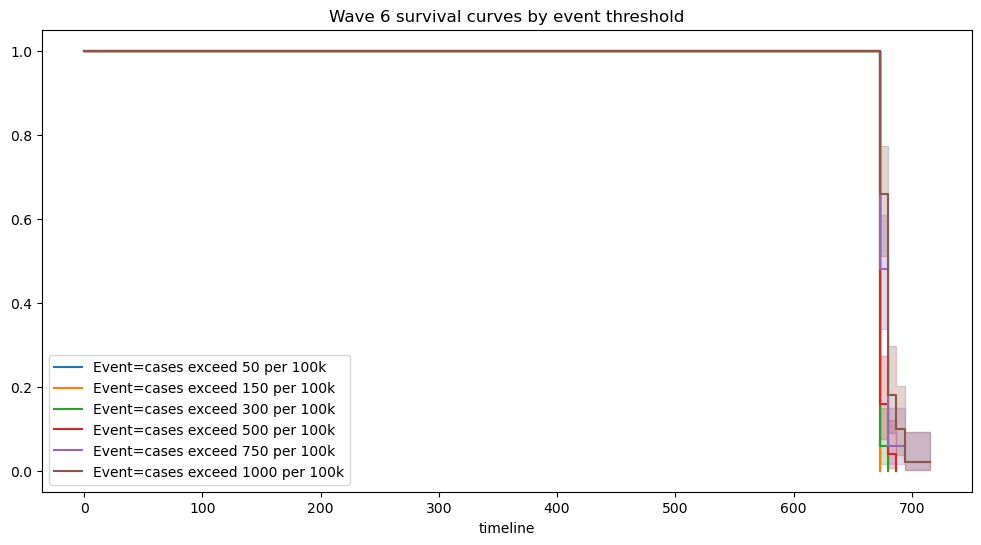

In [144]:
for wave_ix,c in zip(range(1,7), colors):
    for thresh in event_threshold:
        kmf = KaplanMeierFitter()
        censoring_df_for_wave_thresh = censoring_df.loc[(censoring_df.Wave == f'Wave_{wave_ix}') & (censoring_df.event_threshold == thresh)]
        kmf.fit(censoring_df_for_wave_thresh.Date_index, censoring_df_for_wave_thresh.event_indicator)
        kmf.plot(label=f'Event=cases exceed {thresh} per 100k', figsize=(12, 6))
    plt.title(f'Wave {wave_ix} survival curves by event threshold')
    plt.show()
    plt.close()

Fit Cox PH models to see effect of features.

Process demographics data. 

In [145]:
# Add demographics data
demographic_columns = \
np.concatenate([all_data_columns_map[k] for k in ['Demographic_pct_columns', 'Demographic_Median_income', 'Misc_weighted_population_density', 
                                                  'Misc_political', 'Hospital_static_per_100_000_columns']])
demographic_columns = np.setdiff1d(demographic_columns, ['Demographic_Population for whom poverty status is determined','Misc_Republican'])

demographic_df = subnational_df_by_region.first()[demographic_columns]
demographic_df['Demographic_Less than $50,000'] = \
demographic_df[['Demographic_Less than $10,000', 'Demographic_$10,000 to $14,999', 'Demographic_$15,000 to $24,999',
                'Demographic_$25,000 to $34,999', 'Demographic_$35,000 to $49,999']].sum(axis=1)
demographic_columns = \
['Demographic_Less than $50,000', 'Demographic_65 years and over', \
 'Demographic_Black or African American', \
 'Misc_Democratic', 'Misc_Population Density  - weighted [per km2]']
demographic_df = demographic_df[demographic_columns]

demographic_df = demographic_df.reset_index()


censoring_df = pd.merge(
    left=censoring_df, 
    right=demographic_df,
    left_on='RegionName',
    right_on='OxCGRT_RegionName'
)

# for col in demographic_columns:
#     censoring_df[col].hist();plt.title(col); plt.show(); plt.close()

demographic_thresholds = [35, 15, 15, 45, 400]
for col,dthresh in zip(demographic_columns, demographic_thresholds):
    censoring_df[col] = censoring_df[col] >= dthresh

Plot distributions of censoring variables by wave. 

Here we see that majority Democratic areas tend to have event occur later on in the wave. 

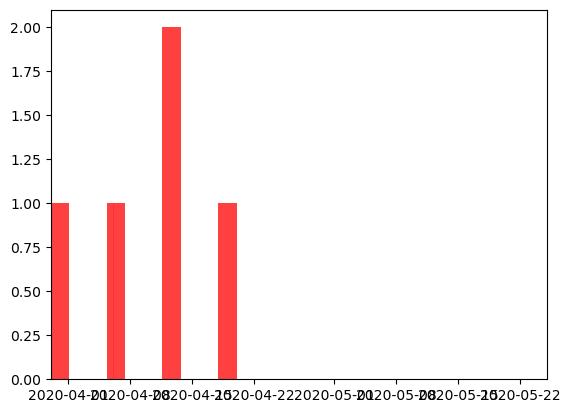

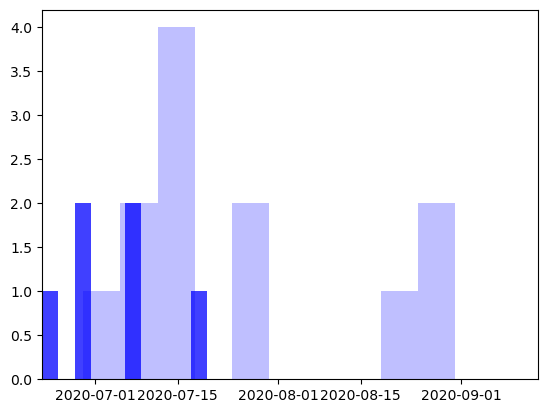

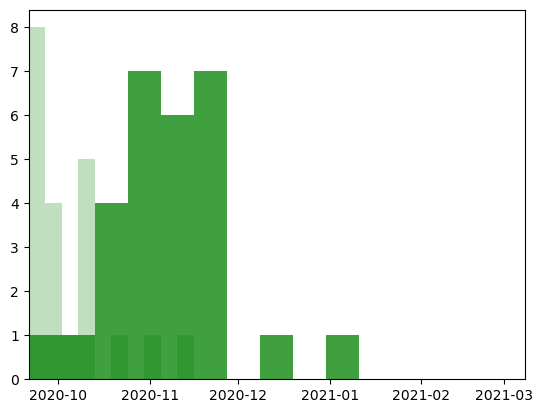

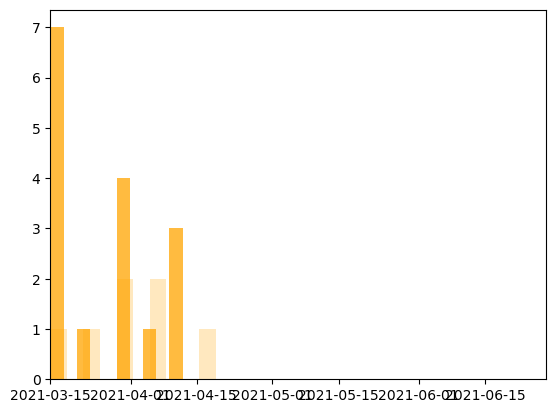

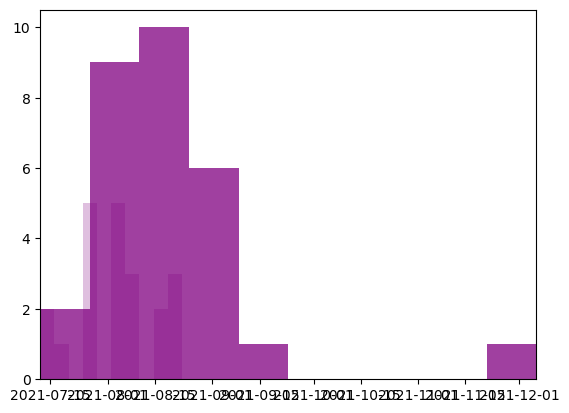

/var/folders/qr/hm7yt1m96p36sgrk07dh1mjw0000gn/T/ipykernel_58551/3536693307.py:11: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(censoring_df_for_wave_thresh.Date.min(), censoring_df_for_wave_thresh.Date.max())


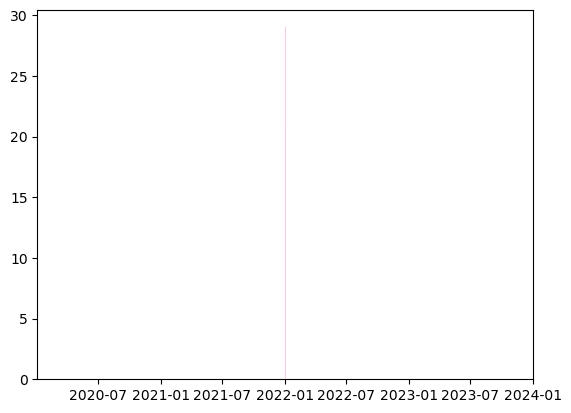

In [161]:
# 1. Plot distributions of censoring variables by wave.
colors = ['red', 'blue', 'green', 'orange', 'purple', 'pink']

for thresh in [150]:
    for wave_ix,c in zip(range(1,7), colors):
        censoring_df_for_wave_thresh = censoring_df.loc[(censoring_df.Wave == f'Wave_{wave_ix}') & (censoring_df.event_threshold == thresh)]
        plt.hist(censoring_df_for_wave_thresh.loc[(censoring_df_for_wave_thresh.event_indicator==1) & 
                                                  (censoring_df_for_wave_thresh.Misc_Democratic==0)].Date, label=f'Wave_{wave_ix}', color=c, alpha=0.25)
        plt.hist(censoring_df_for_wave_thresh.loc[(censoring_df_for_wave_thresh.event_indicator==1) & 
                                                  (censoring_df_for_wave_thresh.Misc_Democratic==1)].Date, label=f'Wave_{wave_ix}', color=c, alpha=0.75)
        plt.xlim(censoring_df_for_wave_thresh.Date.min(), censoring_df_for_wave_thresh.Date.max())
        plt.show();plt.close()

In [173]:
# Fitting Cox Proportional Model
cph = CoxPHFitter()

thresh=150
censoring_df_ = censoring_df[demographic_columns+['Date_index', 'event_indicator', 'event_threshold']]
censoring_df_ = censoring_df_.loc[censoring_df_.event_threshold==thresh][demographic_columns+['Date_index', 'event_indicator']]
# censoring_df_.index=censoring_df_.Date_index

cph.fit(censoring_df_, duration_col='Date_index', event_col='event_indicator')
cph.print_summary(style='ascii')

<lifelines.CoxPHFitter: fitted with 300 total observations, 104 right-censored observations>
             duration col = 'Date_index'
                event col = 'event_indicator'
      baseline estimation = breslow
   number of observations = 300
number of events observed = 196
   partial log-likelihood = -862.21
         time fit was run = 2024-04-20 06:16:04 UTC

---
                                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                      
Demographic_Less than $50,000                  0.08      1.08      0.19           -0.29            0.45                0.75                1.56
Demographic_65 years and over                 -0.10      0.91      0.24           -0.57            0.38                0.57                1.46
Demographic_Black or African American          0.14

Non stationary residuals over time. Indicates need to incorporate time varying covariates. 


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...




   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.5474)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5217)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.4412)'>,
  <Axes: xlabel='km-transformed time\n(p=0.5951)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.2931)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4115)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.1395)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2065)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.3650)'>,
  <Axes: xlabel='km-transformed time\n(p=0.3792)'>]]

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 300 total observations, 104 right-censored observations>
         test_name = proportional_hazard_test

---
                                               test_statistic    p  -log2(p)
Demographic_65 years and over                            0.59 0.44      1.18
Demographic_Black or African American                    1.11 0.29      1.77
Demographic_Less than $50,000                            0.36 0.55      0.87
Misc_Democratic                                          2.18 0.14      2.84
Misc_Population Density  - weighted [per km2]            0.82 0.37      1.45

None


<Axes: xlabel='Date_index', ylabel='deviance'>

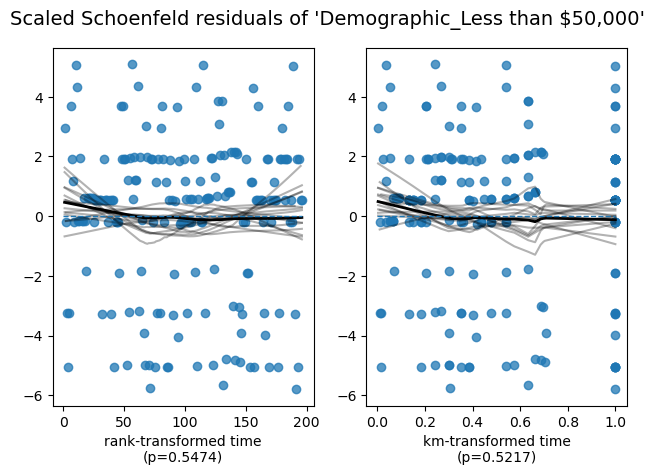

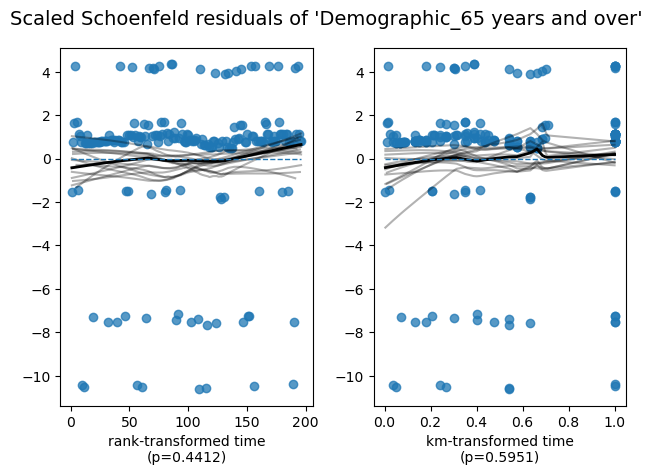

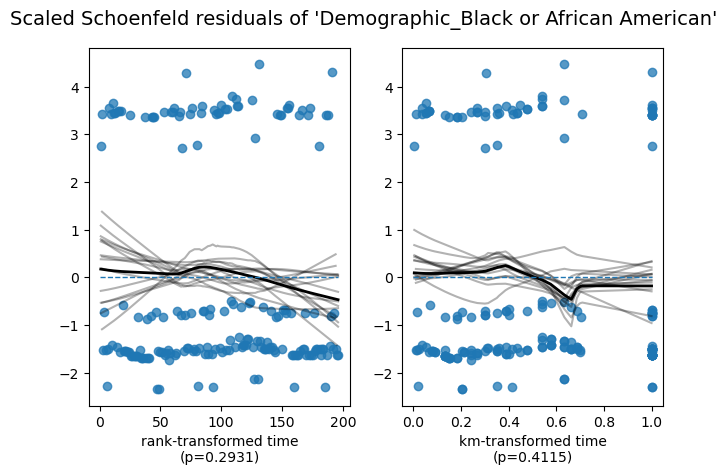

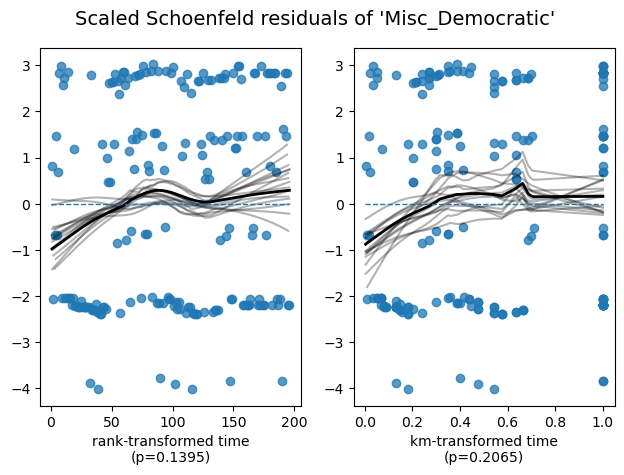

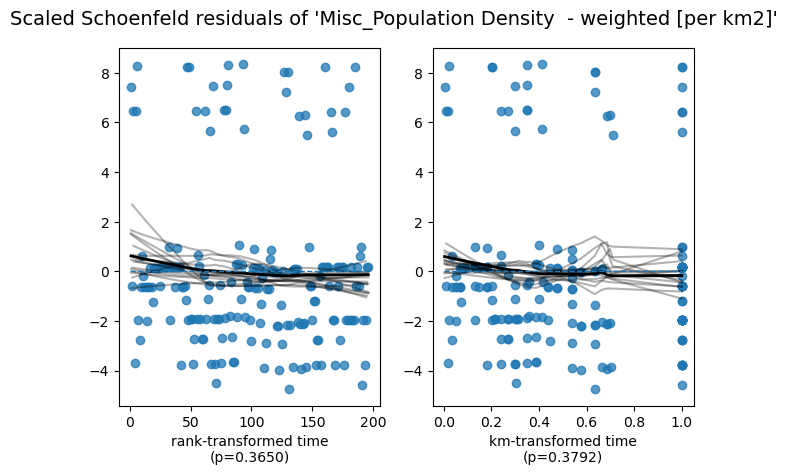

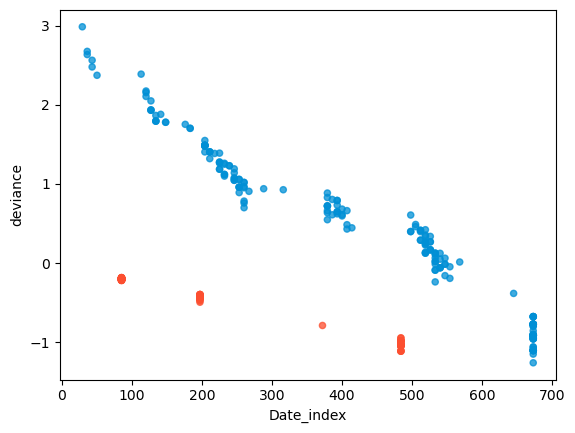

In [249]:
# Check proportional hazards assumptions
from lifelines.statistics import proportional_hazard_test

display(cph.check_assumptions(censoring_df_, p_value_threshold=0.05, show_plots=True))

results = proportional_hazard_test(cph, censoring_df_, time_transform='rank')
print(results.print_summary(decimals=3, model="untransformed variables"))

# Plot residuals over time
r = cph.compute_residuals(censoring_df_, 'deviance')
# r.head()
r.plot.scatter(
    x='Date_index', y='deviance', c=np.where(r['event_indicator'], '#008fd5', '#fc4f30'),
    alpha=0.75
)

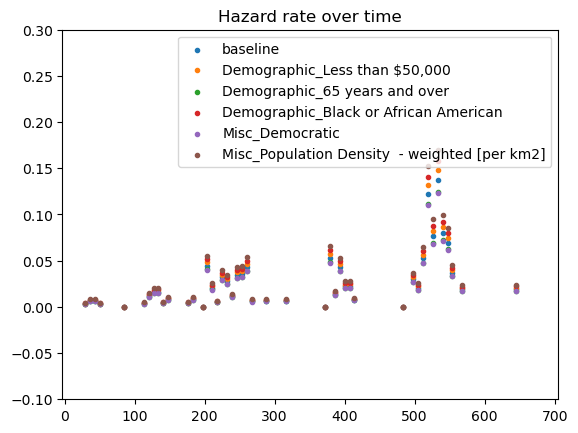

In [187]:
# Plot hazard rates over time.
plt.scatter(cph.baseline_hazard_.index, cph.baseline_hazard_.values, label='baseline', marker='.')
for param_name, param_val in zip(cph.params_.index, cph.params_.values):
    plt.scatter(cph.baseline_hazard_.index, 
                [hj*np.exp(param_val) for hj in cph.baseline_hazard_.values], label=param_name, marker='.')
plt.ylim(-0.1, 0.3)
plt.title('Hazard rate over time')
plt.legend()

Although there is a lot of overlap in the CIs, we see that risk factors like high population density, black or African American race, low income have >1 multiplicative effect on baseline hazard rate. Other feature like majority Democratic political leaning lead to <1 multiplicative effect on baseline hazard rate. Although higher elderly population is a risk factor, it leans towards <1 multiplicative effect. This may be due to association with other features like high vaccination rate, or lower mobility (compared to eg. children). 

<Axes: xlabel='log(HR) (95% CI)'>

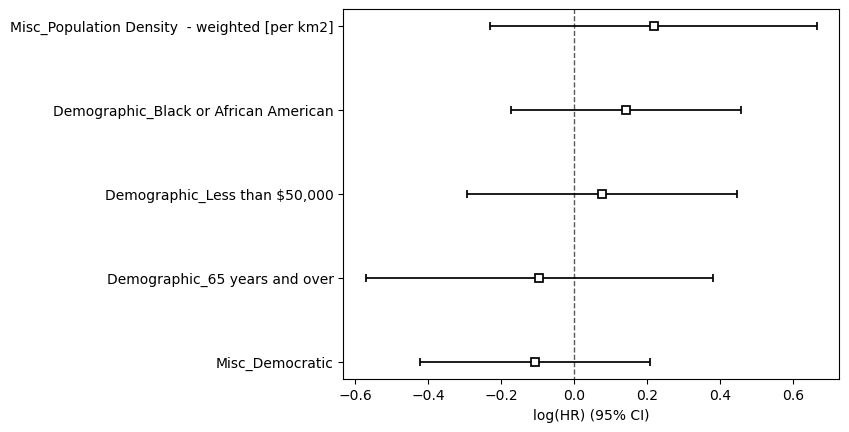

In [164]:
cph.plot()

Contrast survival curves for each feature. CPH and KM. Consistent results. CPH smoother. 

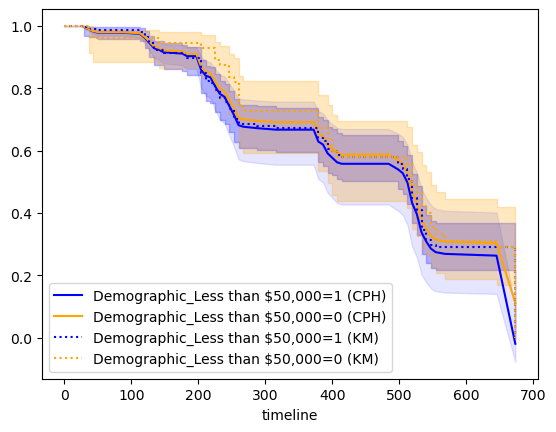

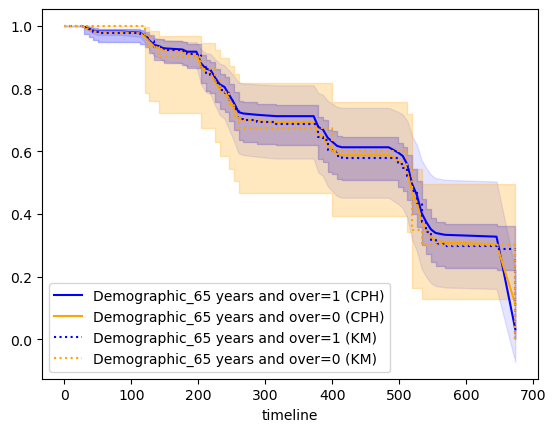

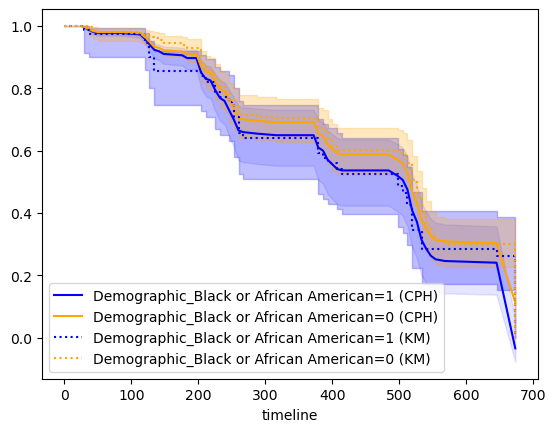

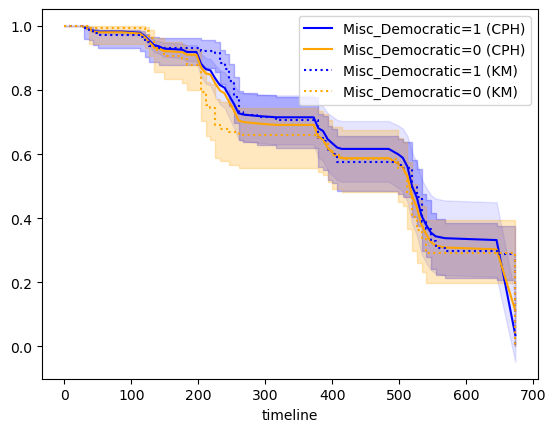

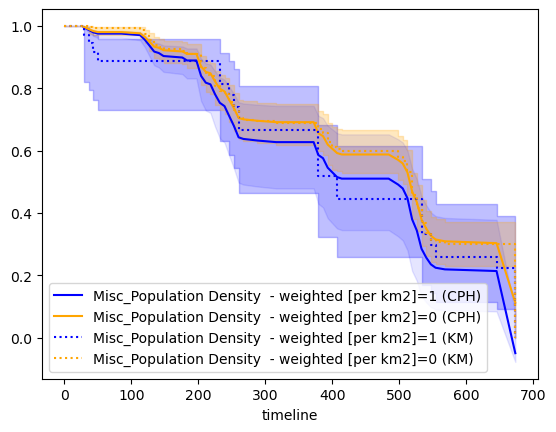

In [237]:
params = pd.merge(left=cph.confidence_intervals_, right=cph.params_, left_index=True, right_index=True)

for cov, param_vals in params.iterrows():
    coef_l, coef_u, coef =param_vals['95% lower-bound'], param_vals['95% upper-bound'], param_vals['coef']
    date_index = cph.baseline_hazard_.index
    hazard_rate_l = [hj*np.exp(coef_l) for hj in cph.baseline_hazard_.values]
    hazard_rate_u = [hj*np.exp(coef_u) for hj in cph.baseline_hazard_.values]
    hazard_rate = [hj*np.exp(coef) for hj in cph.baseline_hazard_.values]

    survival_df_param1 = pd.DataFrame(np.hstack((
        np.cumprod([1-hj for hj in hazard_rate_l])[:, None],
        np.cumprod([1-hj for hj in hazard_rate_u])[:, None],
        np.cumprod([1-hj for hj in hazard_rate])[:, None]
    )), columns=['lower', 'upper', 'mean'])

    fig,ax=plt.subplots()
    ax.plot(date_index, survival_df_param1['mean'], label=f'{cov}=1 (CPH)', color='blue')
    ax.plot(date_index, cph.baseline_survival_.iloc[:, 0].values, label=f'{cov}=0 (CPH)', color='orange')
    ax.fill_between(date_index, survival_df_param1.lower, survival_df_param1.upper, alpha=0.1, color='blue')
    # cph.plot_covariate_groups(cov, [1, 0], plot_baseline=False, figsize=(10, 6), lw=1, ax=ax)

    kmf = KaplanMeierFitter()
    for x,c in zip([1,0], ['blue', 'orange']):
        kmf.fit(censoring_df_.loc[censoring_df_[cov] == x].Date_index, censoring_df_.loc[censoring_df_[cov] == x].event_indicator)
        kmf.plot_survival_function(ax=ax, label=f'{cov}={x} (KM)', color=c, linestyle=':')
    
    # plt.title(f'Wave {wave_ix} survival curves by event threshold')
    plt.legend()
    plt.show()
    plt.close()

